In [17]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import pandas as pd
import numpy as np
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Conv2D, Flatten, Dropout, MaxPooling2D, Activation
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt

from IPython.display import display, clear_output

In [ ]:
#check if tensorflow is built with cuda
import tensorflow as tf
from tensorflow.python.client import device_lib

print(f'Built with cuda: {tf.test.is_built_with_cuda()}' )
print(f'Tensorflow version: {tf.__version__}')
print(device_lib.list_local_devices())

In [3]:
#enable memory growth for gpu
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [4]:
def raw_confusion_matrix(y_true, y_pred_probs, labels):
    
    y_pred = np.argmax(y_pred_probs, axis=1)

    y_true = np.argmax(y_true, axis=1)

    cm = confusion_matrix(y_true, y_pred)

    #plotting
    plt.figure(figsize=(10,7))
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xticks(rotation=45)
    ax.invert_xaxis()

    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

def fluffy_confusion_matrix(y_true, y_pred_probs, labels, N):
    num_samples, num_classes = y_pred_probs.shape

    conf_matrix = np.zeros((num_classes, num_classes))

    for i in range(num_samples):
        true_class = y_true[i]

        #indices of top N predictions, descending
        top_n_preds = np.argsort(y_pred_probs[i])[-N:][::-1]

        #softmax scores of top N predictions
        top_n_scores = y_pred_probs[i][top_n_preds]  
        
        #normalize scores to sum to 1 for proportional distribution
        normalized_scores = top_n_scores / np.sum(top_n_scores)
        
        #distribute votes
        for j, pred_class in enumerate(top_n_preds):
            conf_matrix[np.argmax(true_class), pred_class] += normalized_scores[j]
    
    plt.figure(figsize=(12, 10))
    ax = sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Fluffy Confusion Matrix with Proportional Distribution')

    ax.invert_xaxis()
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)

    plt.show()

def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [5]:
dataset_train_base = "/mnt/c/Users/olson/OneDrive - Kennesaw State University/Desktop/School/Machine Learning/Facial Expression Recognition/train"
dataset_validation_base = "/mnt/c/Users/olson/OneDrive - Kennesaw State University/Desktop/School/Machine Learning/Facial Expression Recognition/validation"

In [6]:
class_list = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
class_count = len(class_list)
image_size = (48, 48)
batch_size = 128

In [7]:
#using int label for sparse categorical crossentropy
#dataset is grayscale, so we will have one channel in the CNN

train_dataset = image_dataset_from_directory(
    dataset_train_base,
    labels='inferred',
    label_mode='categorical',
    class_names=class_list,
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True,
    seed=42
)

validation_dataset = image_dataset_from_directory(
    dataset_validation_base,
    labels='inferred',
    label_mode='categorical',
    class_names=class_list,
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True,
    seed=42
)

Found 28821 files belonging to 7 classes.
Found 7066 files belonging to 7 classes.


In [9]:
#number of data points for each class
train_class_counts = {}
validation_class_counts = {}

dataset_class_list = train_dataset.class_names

for images, labels in train_dataset:
    for label in labels:
        train_class_counts[dataset_class_list[np.argmax(label)]] = train_class_counts.get(dataset_class_list[np.argmax(label)], 0) + 1

for images, labels in validation_dataset:
    for label in labels:
        validation_class_counts[dataset_class_list[np.argmax(label)]] = validation_class_counts.get(dataset_class_list[np.argmax(label)], 0) + 1

print(f'Train class counts: {train_class_counts}')
print(f'Validation class counts: {validation_class_counts}')

Train class counts: {'angry': 3993, 'neutral': 4982, 'fear': 4103, 'happy': 7164, 'sad': 4938, 'surprise': 3205, 'disgust': 436}
Validation class counts: {'happy': 1825, 'angry': 960, 'fear': 1018, 'surprise': 797, 'neutral': 1216, 'disgust': 111, 'sad': 1139}


In [12]:
#class weights for imbalanced dataset
train_class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(list(train_class_counts.keys())),
    y=list(train_class_counts.keys()))

train_class_weight_dict = {i: weight for i, weight in enumerate(train_class_weights)}

print(train_class_weight_dict)

{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0}


In [13]:
with tf.device('/GPU:0'):
    model = Sequential([

        Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 1)),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Flatten(),

        Dense(256, activation='relu'),
        Dropout(0.6),

        Dense(128, activation='relu'),
        Dropout(0.4),

        Dense(128, activation='relu'),
        Dropout(0.3),

        Dense(class_count, activation='softmax')
    ])

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

/home/qolson/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 667,527 (2.55 MB)

 Trainable params: 667,527 (2.55 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Monitor the validation accuracy
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restores model weights from the epoch with the best value of the monitored quantity
    verbose=1  # To see the output for early stopping
)

with tf.device('/GPU:0'):
    history = model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=100,
        class_weight=train_class_weight_dict,
        callbacks=[early_stopping]
    )

Epoch 1/100


226/226 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - accuracy: 0.4990 - loss: 1.2940 - val_accuracy: 0.5020 - val_loss: 1.3186
Epoch 2/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - accuracy: 0.5111 - loss: 1.2596 - val_accuracy: 0.5035 - val_loss: 1.2915
Epoch 3/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.5262 - loss: 1.2337 - val_accuracy: 0.5051 - val_loss: 1.3023
Epoch 4/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.5369 - loss: 1.2130 - val_accuracy: 0.5103 - val_loss: 1.2917
Epoch 5/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - accuracy: 0.5451 - loss: 1.1847 - val_accuracy: 0.5142 - val_loss: 1.2813
Epoch 6/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.5609 - loss: 1.1508 - val_accuracy: 0.5177 - val_loss: 1.2798
Epoch 7/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - accuracy: 0.5688 - loss: 1.1267 - val_accuracy: 0.5168 - val_loss: 1.2888
Epoch 8/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.5716 - loss: 1.1114 - val_

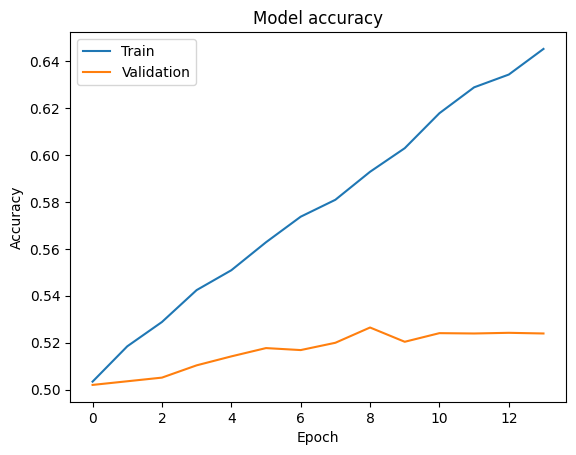

56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step


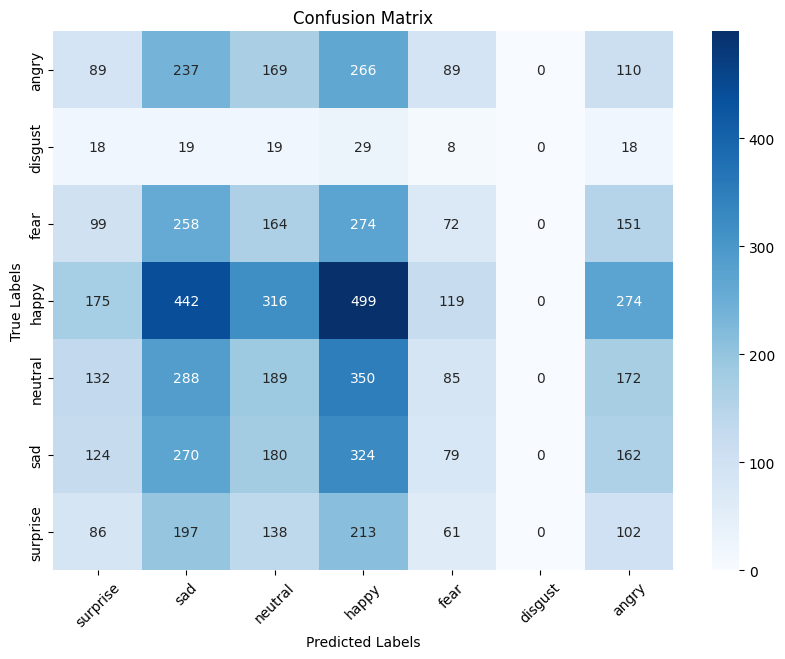

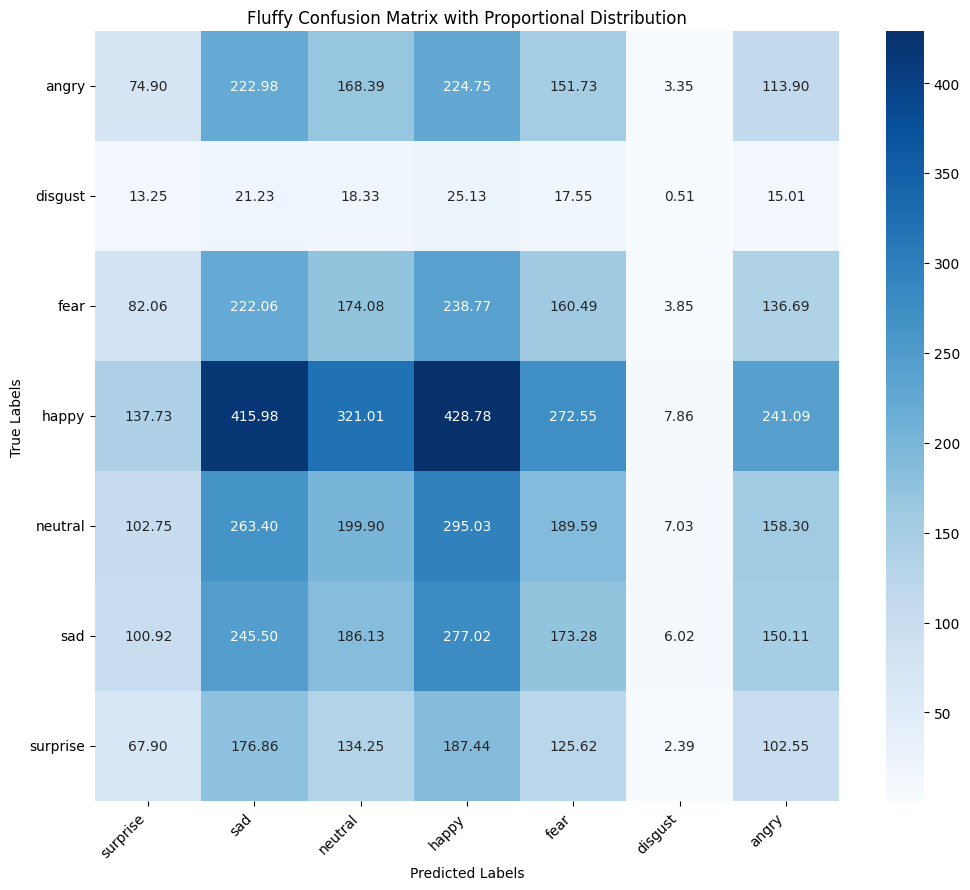

In [19]:
plot_accuracy(history)

#confusion matrix
y_test = np.concatenate([y for x, y in validation_dataset], axis=0)
y_pred = model.predict(validation_dataset)

raw_confusion_matrix(y_test, y_pred, class_list)
fluffy_confusion_matrix(y_test, y_pred, class_list, 3)